In [1]:
import numpy as np 
import pandas as pd 
import sklearn
import scipy.sparse
import lightgbm as lgb
import gc 
import matplotlib.pyplot as plt 
import warnings
from pandas import HDFStore
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')



pd.set_option('display.max_rows',600)
pd.set_option('display.max_columns',50)


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product 

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df


In [3]:
store = HDFStore('all_data.h5')
all_data = store['all_data']


### Data Cleaning and exploration
* duplicates (done)
* missing values (done) 
* outliers (done) 
* EDA
 * histograms and scatterplots 


#### Loading all the datasets 

In [4]:
data_path = 'C:/Code/Data Science Code Base/Kaggle Data/Predict_Future_Sales/'
sales = pd.read_csv(data_path+'sales_train_v2.csv')
shops = pd.read_csv(data_path+'shops-translated.csv')
items = pd.read_csv(data_path+'items-translated.csv')
item_cats = pd.read_csv(data_path+'item_categories-translated.csv')
test = pd.read_csv(data_path+'test.csv')

##### Dealing with duplicates 
* Sales
* Items 
* Shops
* Item_categories



In [5]:
sales.drop_duplicates(inplace=True)
shops.drop_duplicates(inplace=True)
items.drop_duplicates(inplace=True)
item_cats.drop_duplicates(inplace=True)

In [6]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


##### Missing Values
* None have missing values 


##### Outliers 
* item_price 
* item_cnt_day


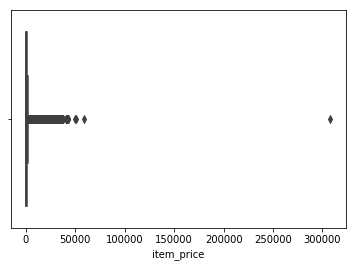

In [7]:
sns.boxplot(sales['item_price'])

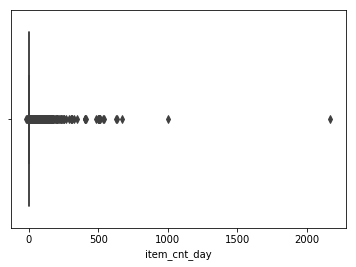

In [8]:
sns.boxplot(sales.item_cnt_day)

###### Removing outliers from sales 

In [9]:
sales = sales[sales.item_cnt_day<1000]
sales = sales[sales.item_price<100000]
sales = sales[sales.item_price>0]

#### Exploratory Data Analysis

The possible amount of item/shop combinations is much lower than total possible combinations 

In [10]:
sales[['item_id','shop_id']].drop_duplicates().shape[0]/(sales.item_id.nunique()*sales.shop_id.nunique())

0.3241638386988291

##### Most of the item_prices are between 0-10,000

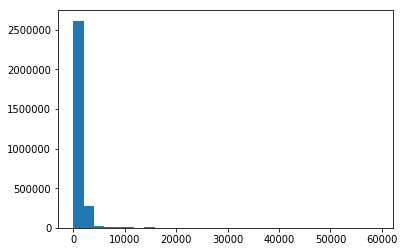

In [11]:
plt.hist(sales.item_price,bins=30)
plt.show()

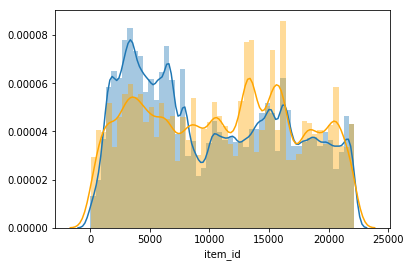

In [18]:
plt.figure()
sns.distplot(sales.item_id,hist=True)
sns.distplot(test.item_id,hist=True,color='orange')

There are many new items in test set (363)

In [22]:
len(list(set(test.item_id)-set(sales.item_id)))

363

Same shops, but new items, so many predictions will be zero in the test set, cause new items. Test set generated by taking shop item pairs? Validation strategy grid of all possible combinations good, already got it but trying to understand the process


In [23]:
len(list(set(test.shop_id)-set(sales.shop_id)))

0

In [24]:
test.groupby('shop_id').size()

shop_id
2     5100
3     5100
4     5100
5     5100
6     5100
7     5100
10    5100
12    5100
14    5100
15    5100
16    5100
18    5100
19    5100
21    5100
22    5100
24    5100
25    5100
26    5100
28    5100
31    5100
34    5100
35    5100
36    5100
37    5100
38    5100
39    5100
41    5100
42    5100
44    5100
45    5100
46    5100
47    5100
48    5100
49    5100
50    5100
52    5100
53    5100
55    5100
56    5100
57    5100
58    5100
59    5100
dtype: int64

### Feature Engineering 
* Add item/shop month aggregates
* Add shop names and item categories 
* Extract city name or some info from shop names 
* Add expensive variable (cheap,mid-range,expensive)(
* Prepare Grid and merge with grouped aggregates (Validation strategy)
* Number of holidays in that month 
* Add month
* Add Lag Features 
* Add Trends(item,shop,dateblocknum),mean target value in past 6,12 months 
* Mean encode all these features  

In [3]:
index_cols = ['shop_id','item_id','date_block_num']
shift_range = [1,2,3,4,5,12]
fit_cols  = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]
to_drop_cols = list(set(list(all_data.columns))-(set(fit_cols)|set(index_cols))) + ['date_block_num']

In [4]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,12,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,12,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


In [24]:
dates = all_data['date_block_num']
last_block = dates.max()

dates_train = dates[dates<last_block]
dates_test = dates[dates==last_block]

X_train = all_data.loc[dates<last_block].drop(to_drop_cols,axis=1)
X_test = all_data.loc[dates==last_block].drop(to_drop_cols,axis=1)

y_train = all_data.loc[dates<last_block,'target'].values
y_test = all_data.loc[dates==last_block,'target'].values

In [27]:
lgb_params = {
                'feature_fraction':0.75,
                'metric':'rmse',
                'nthread':3,
                'min_data_in_leaf':2**5,
                'bagging_fraction':0.75,
                'learning_rate':0.25,
                'objective':'mse',
                'bagging_seed':2**7,
                'max_depth':20,
                'num_leaves':2**9,
                'bagging_freq':1,
                'verbose':0
            }

model = lgb.train(lgb_params,lgb.Dataset(X_train,label=y_train),num_boost_round=200)
pred_lgb_val = model.predict(X_test)
pred_lgb_tr = model.predict(X_train)


print('Test Rmse for LightGBM is %f'% np.sqrt( mean_squared_error(y_test,pred_lgb_val)))
print('Test R-squared for LightGBM is %f'% r2_score(y_test,pred_lgb_val))
print('Train Rmse for LightGBM is %f'% np.sqrt(mean_squared_error(y_train,pred_lgb_tr)))
print('Train R-squared for LightGBM is %f'% r2_score(y_train,pred_lgb_tr))


Test Rmse for LightGBM is 4.651816
Test R-squared for LightGBM is 0.241917
Train Rmse for LightGBM is 1.984050
Train R-squared for LightGBM is 0.708424


In [26]:
np.sqrt(4)

2.0